# 机器学习方法
特征：
1. 滑动窗口采样
设置windows size，采样前k个step预测下一个

2. 滑动窗口平均采样

模型：
1. 线性回归
2. 逻辑回归
3. xgboost


In [2]:
import pandas as pd
import numpy as np
import random
import pickle
import math
import os
import scipy.io
import matplotlib.pyplot as plt
%matplotlib inline

from math import sqrt
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# 1 读取处理后数据

字典数据：
```
{
    'tid':[
        [cycle_count],
        [battery_life]
    ]
}
```

DataFrame数据：
```
columns = [tid,cycle_count,life]
```

In [25]:
bmap = pickle.load(open("../data/processed/nasa-li-battery_dict_240906.pkl",'rb'))

In [26]:
ddf = pd.read_pickle('../data/processed/nasa-li-battery_df_240906.pkl')

# 2 特征采样和评价指标

## 2.1 特征采样

In [41]:
window_size = 10

In [ ]:
np.r_()

In [73]:
def build_sequences(text, window_size):
    #text:list of capacity
    x, y = [],[]
    for i in range(len(text) - window_size):
        sequence = text[i:i+window_size]
        target = text[i+1:i+1+window_size]

        x.append(sequence)
        y.append(target)
        
    return np.array(x), np.array(y)


# 留一评估：一组数据为测试集，其他所有数据全部拿来训练
def get_train_test(data_dict, name, window_size=8, train_ratio=0.):
    data_sequence=data_dict[name][1]
    train_data, test_data = data_sequence[:window_size+1], data_sequence[window_size+1:]
    train_x, train_y = build_sequences(text=train_data, window_size=window_size)
    for k, v in data_dict.items():
        if k != name:
            data_x, data_y = build_sequences(text=v[1], window_size=window_size)
            train_x, train_y = np.r_[train_x, data_x], np.r_[train_y, data_y]
            
    return train_x, train_y, list(train_data), list(test_data)


def evaluation(y_test, y_predict):
    mae = mean_absolute_error(y_test, y_predict)
    mse = mean_squared_error(y_test, y_predict)
    rmse = sqrt(mean_squared_error(y_test, y_predict))
    return mae, rmse
    

def relative_error(y_test, y_predict, threshold):
    true_re, pred_re = len(y_test), 0
    for i in range(len(y_test)-1):
        if y_test[i] <= threshold >= y_test[i+1]:
            true_re = i - 1
            break
    for i in range(len(y_predict)-1):
        if y_predict[i] <= threshold:
            pred_re = i - 1
            break
    return abs(true_re - pred_re)/true_re

## 2.2 训练和评价

In [146]:
from tqdm import tqdm

### 训练器

In [491]:
def regressor_trainer(skmodel,
                      data_dict,
                      window_size=10,
                      epoch=1000,
                      eval_step=10,
                    on_test_log=False):
    mae_lst,rmse_lst = [], []
    for i in tqdm(range(epoch)):
        if i%eval_step==0 and on_test_log:
            print('---------------------------------------------------')
        for name in data_dict.keys():
            train_x, train_y, train_data, test_data = get_train_test(data_dict, name, window_size)
            real_train_y = train_y[:,-1]
            
            test_x = train_data.copy()
        
            # (batch, window_size)-->(batch, 1)
            skmodel.fit(train_x,real_train_y)
    
            # Eval on every eval_step
            if (i+1)%eval_step==0:
                test_x = train_data.copy()
                point_list = []
                while (len(test_x) - len(train_data)) < len(test_data):
                    online_x = np.reshape(np.array(test_x[-window_size:]), (-1, window_size)).astype(np.float32)
            
                    next_point = skmodel.predict(online_x)[0]
                    
                    test_x.append(next_point)#测试值加入原来序列用来继续预测下一个点
                    point_list.append(next_point)#保存输出序列最后一个点的预测值
                
                mae, rmse = evaluation(y_test=test_data, y_predict=point_list)

                mae_lst.append(mae)
                rmse_lst.append(rmse)

                if on_test_log:
                    print(f'Epoch:{i} {name} MAE:{mae:.4f} | RMSE:{rmse:<6.4f}')
    print(f'Model:{skmodel.__str__()}')
    print(f'MAE:{np.average(mae_lst):.4f} RMSE:{np.average(rmse_lst):.4f}')
    return skmodel

### 预测绘图

In [216]:
def regressor_line_predictor(skmodel,
                      data_dict,
                      window_size=10):
    plot_dict = {}
    for name in data_dict.keys():
        train_x, train_y, train_data, test_data = get_train_test(data_dict, name, window_size)
        real_train_y = train_y[:,-1]
        
        test_x = train_data.copy()
        point_list = []
        while (len(test_x) - len(train_data)) < len(test_data):
            online_x = np.reshape(np.array(test_x[-window_size:]), (-1, window_size)).astype(np.float32)
    
            next_point = skmodel.predict(online_x)[0]
            
            test_x.append(next_point)#测试值加入原来序列用来继续预测下一个点
            point_list.append(next_point)#保存输出序列最后一个点的预测值
        
        plot_dict[name] = {}
        plot_dict[name]['real'] = data_dict[name][1]
        plot_dict[name]['pred'] = test_x
    return plot_dict

### 绘图函数

In [224]:
def plot(name,
         real_data, 
         pred_data):
    fig, ax = plt.subplots(1, figsize=(12, 8))

    plot_range = [i for i in range(len(real_data))]
    
    ax.plot(plot_range, real_data, 'b.', label=name)
    ax.plot(plot_range, pred_data, 'r.', label='Prediction')
    plt.plot([-1,170],[2*0.7, 2*0.7], c='black', lw=1, ls='--')  # 临界点直线
    ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Capacity degradation at ambient temperature of 24°C')
    plt.legend()

# 3 线性回归模型

## 3.1 RANSAC回归

In [155]:
from sklearn.linear_model import RANSACRegressor

In [232]:
model = RANSACRegressor()

In [233]:
model = regressor_trainer(model,bmap)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:32<00:00, 30.83it/s]

Model:RANSACRegressor()
MAE:0.0944 RMSE:0.1033


In [234]:
plot_data = regressor_line_predictor(model,bmap)   

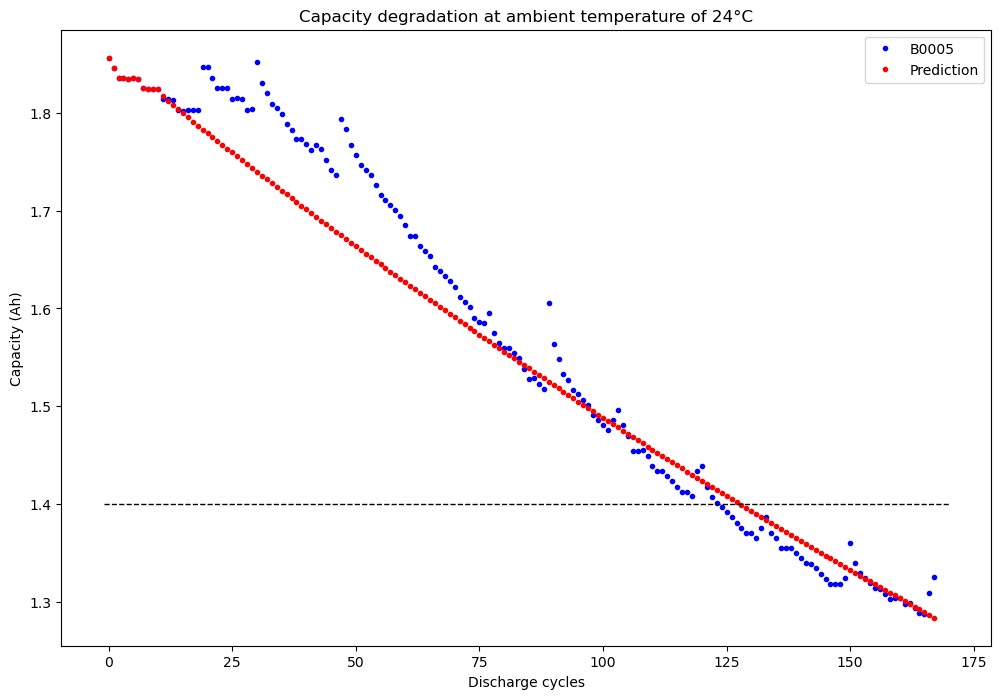

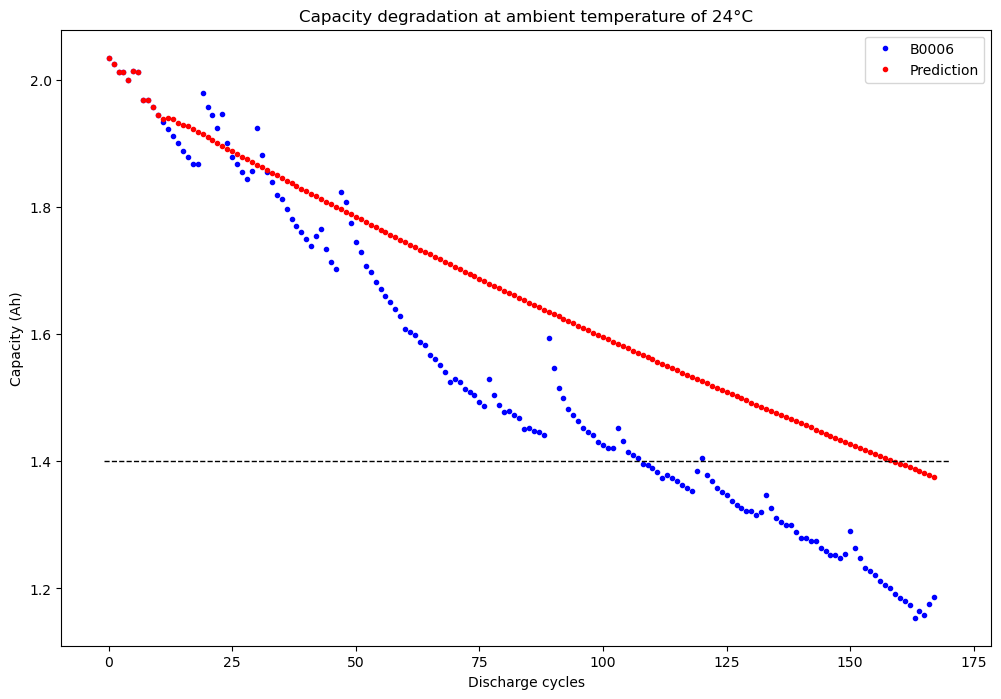

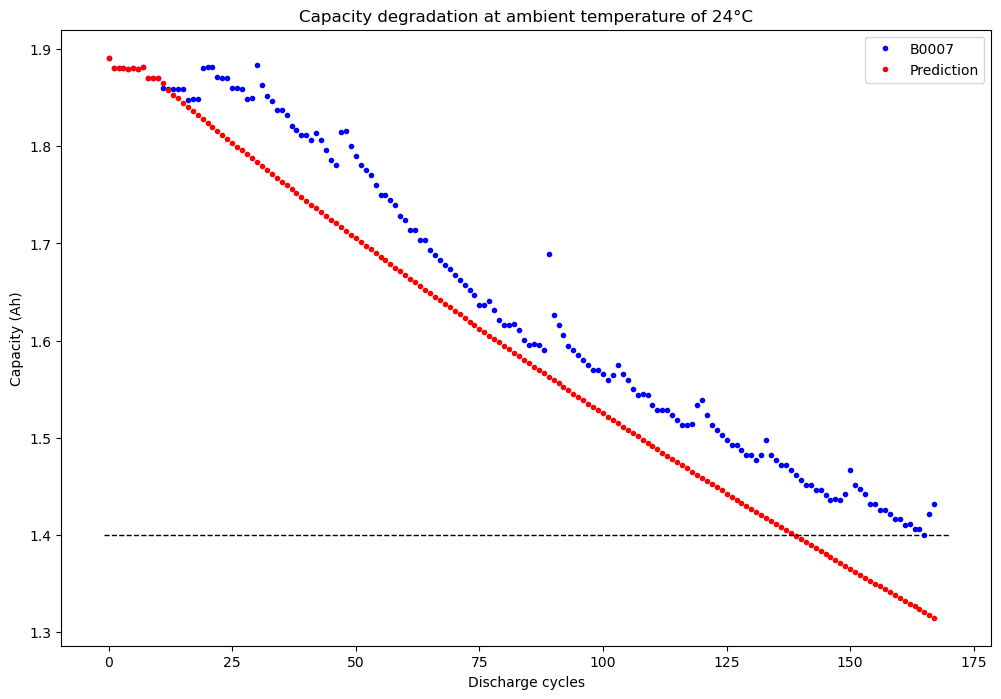

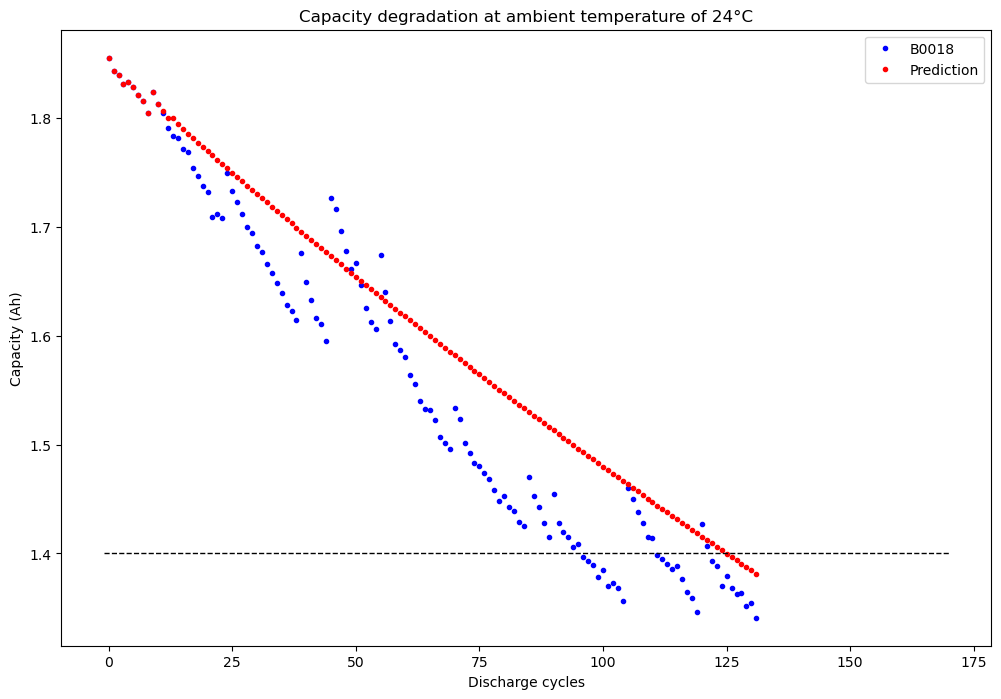

In [235]:
for name in plot_data:
    real,pred = plot_data[name]['real'], plot_data[name]['pred']
    plot(name=name,
         real_data=real,
        pred_data=pred)

## 3.2 SGD回归

In [158]:
from sklearn.linear_model import SGDRegressor

In [236]:
model = SGDRegressor()

In [237]:
model = regressor_trainer(model,bmap)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 102.08it/s]

Model:SGDRegressor()
MAE:0.0863 RMSE:0.0967


In [238]:
plot_data = regressor_line_predictor(model,bmap)   

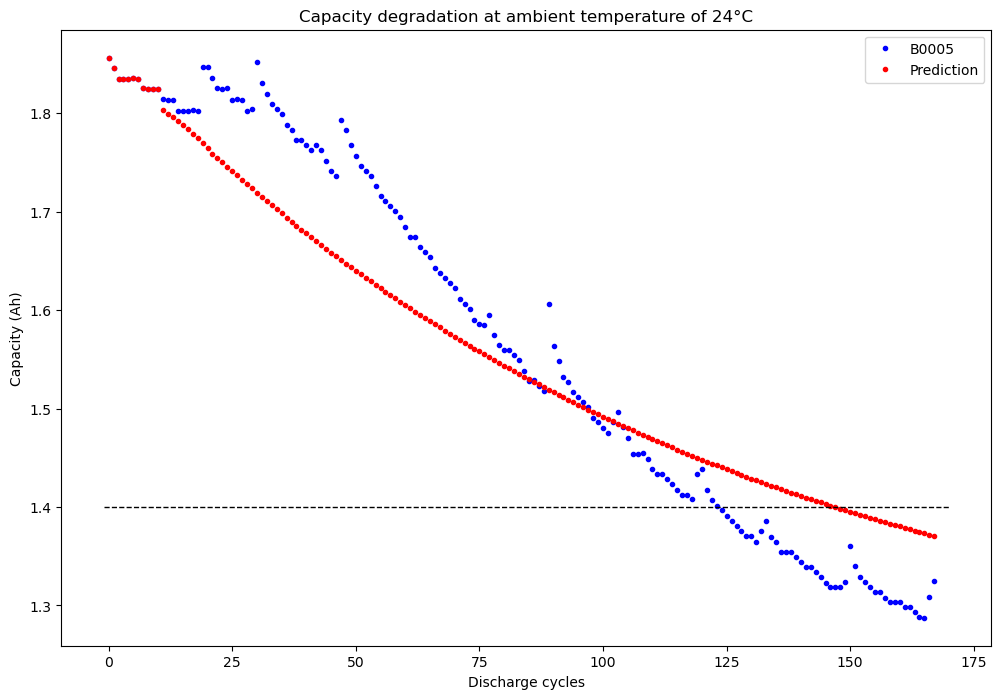

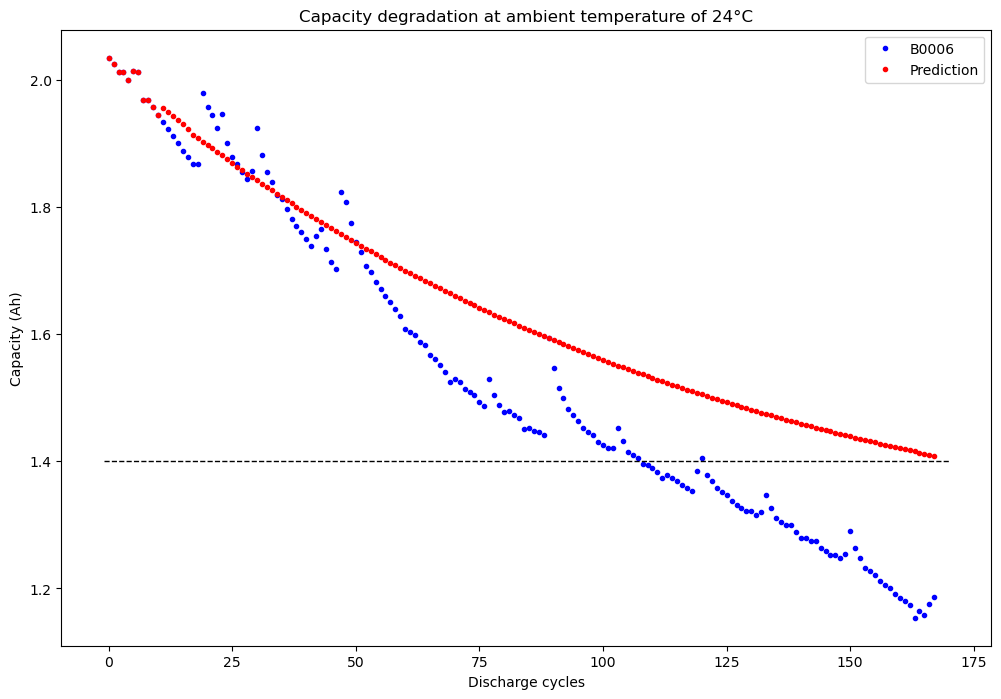

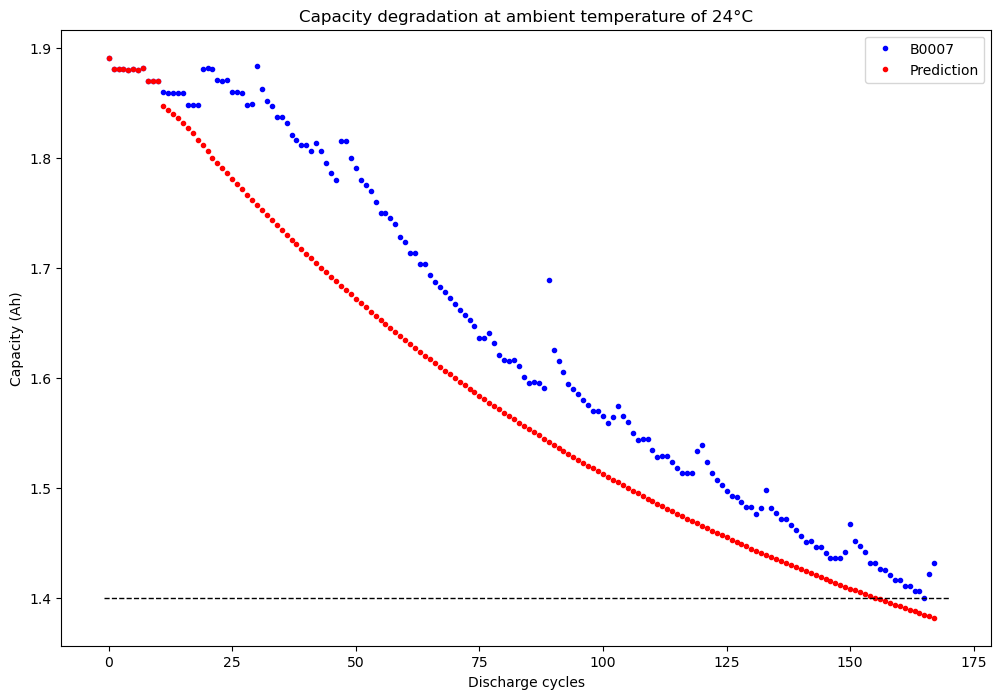

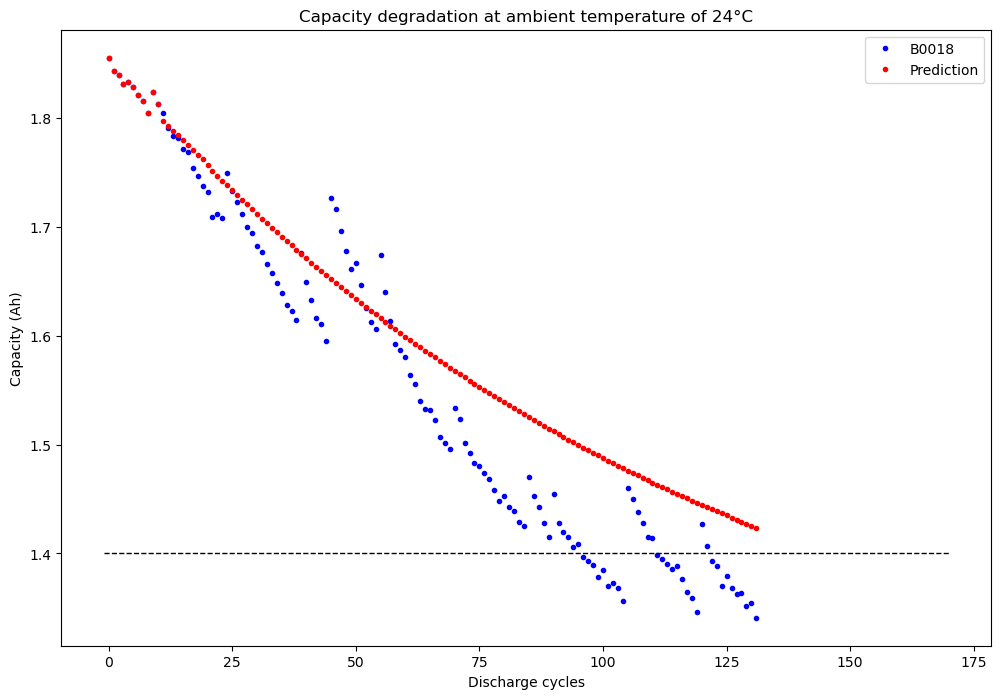

In [239]:
for name in plot_data:
    real,pred = plot_data[name]['real'], plot_data[name]['pred']
    plot(name=name,
         real_data=real,
        pred_data=pred)

## 3.3 岭回归

In [163]:
from sklearn.linear_model import PoissonRegressor

In [240]:
model = PoissonRegressor()

In [241]:
model = regressor_trainer(model,bmap)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:32<00:00, 30.35it/s]

Model:PoissonRegressor()
MAE:0.1536 RMSE:0.1764


In [242]:
plot_data = regressor_line_predictor(model,bmap)   

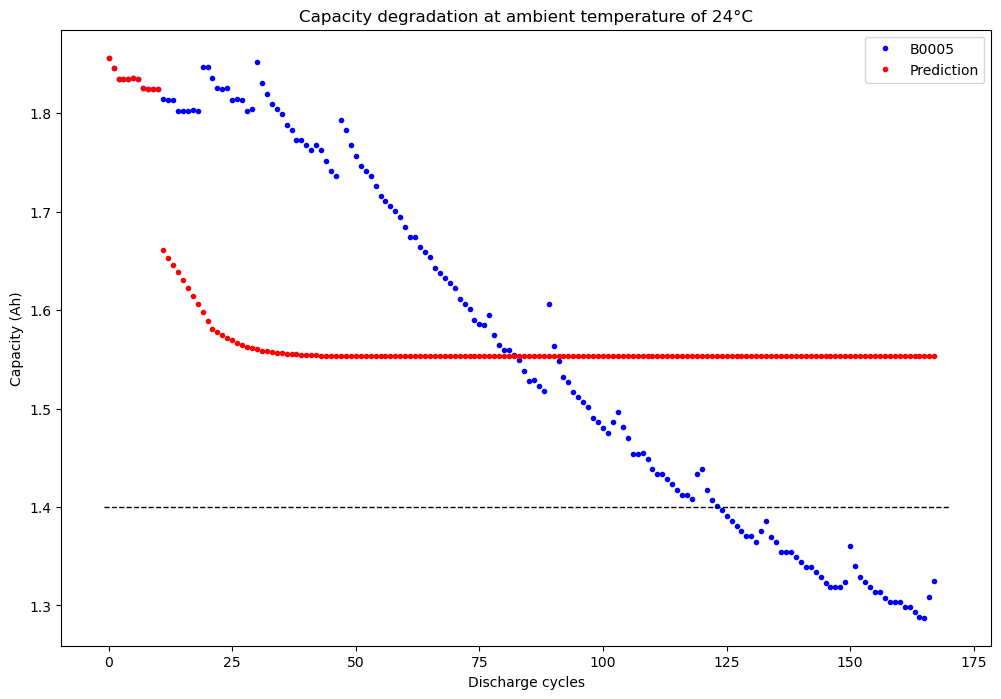

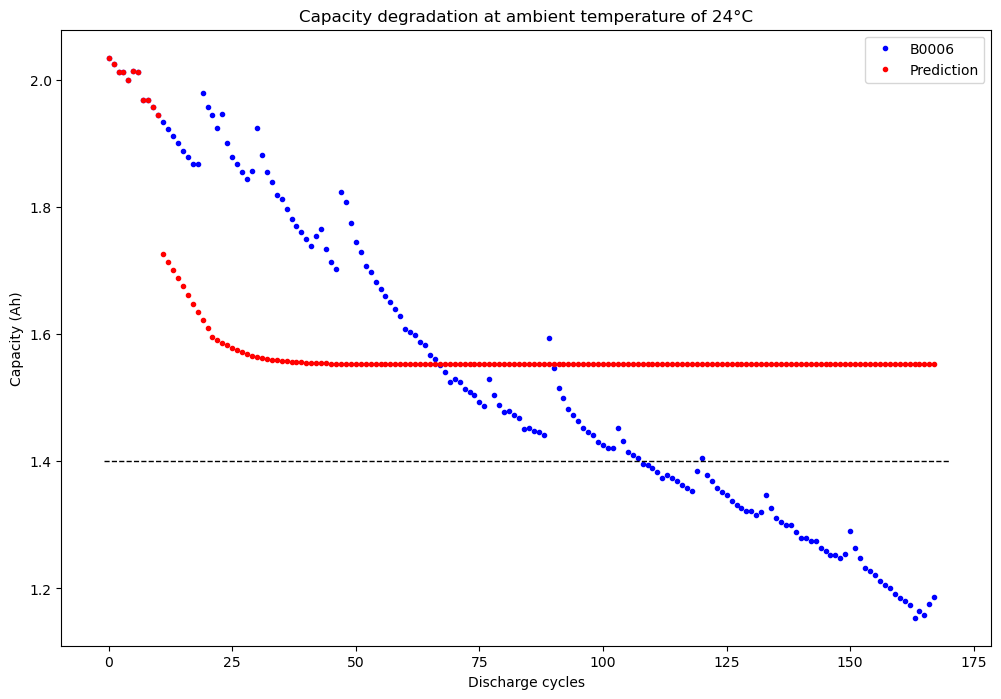

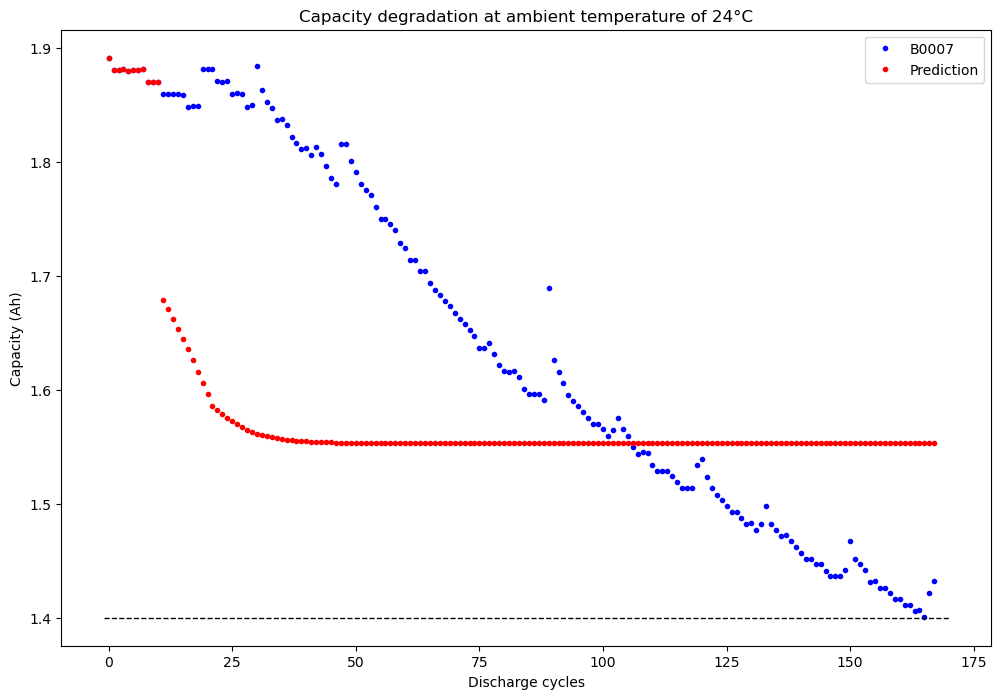

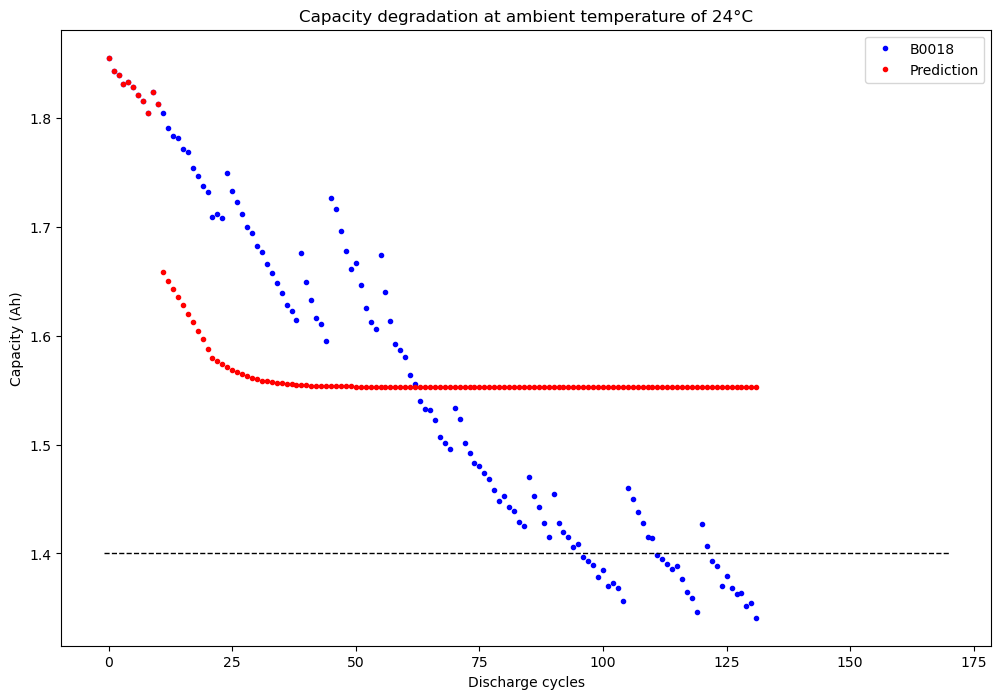

In [243]:
for name in plot_data:
    real,pred = plot_data[name]['real'], plot_data[name]['pred']
    plot(name=name,
         real_data=real,
        pred_data=pred)

## 3.4 PassiveAggressive回归

In [168]:
from sklearn.linear_model import PassiveAggressiveRegressor

In [244]:
model = PassiveAggressiveRegressor()

In [245]:
model = regressor_trainer(model,bmap)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 116.38it/s]

Model:PassiveAggressiveRegressor()
MAE:0.4540 RMSE:0.5151


In [246]:
plot_data = regressor_line_predictor(model,bmap)   

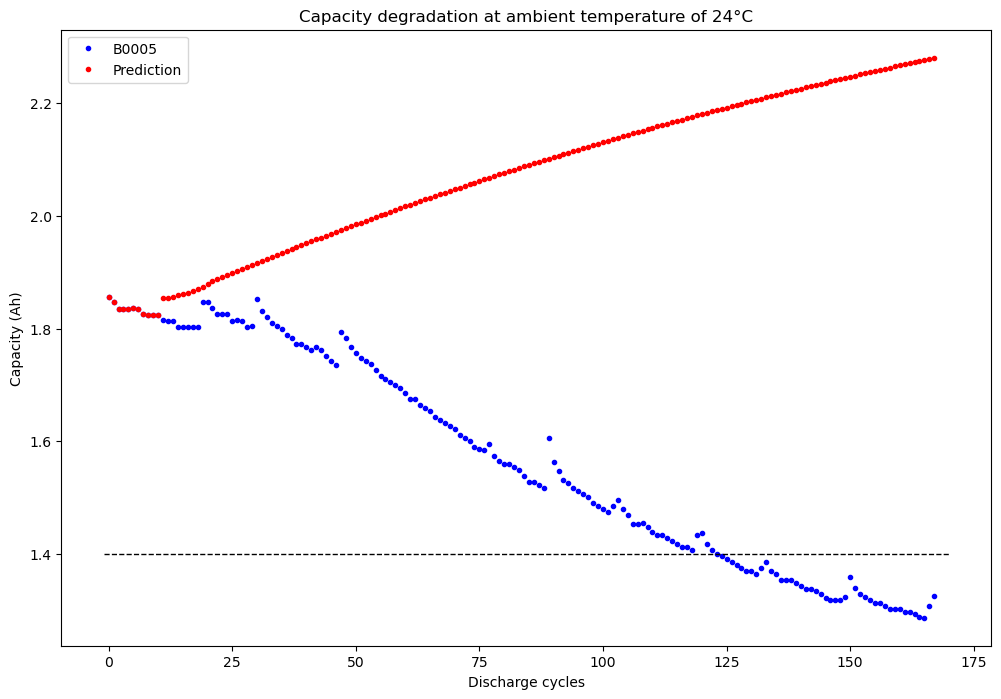

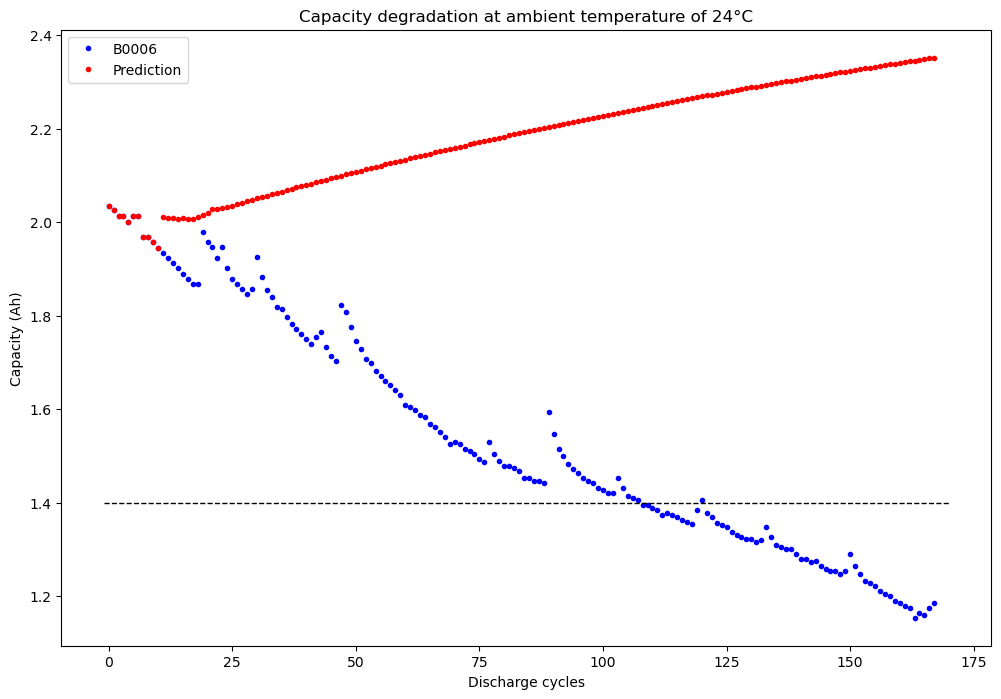

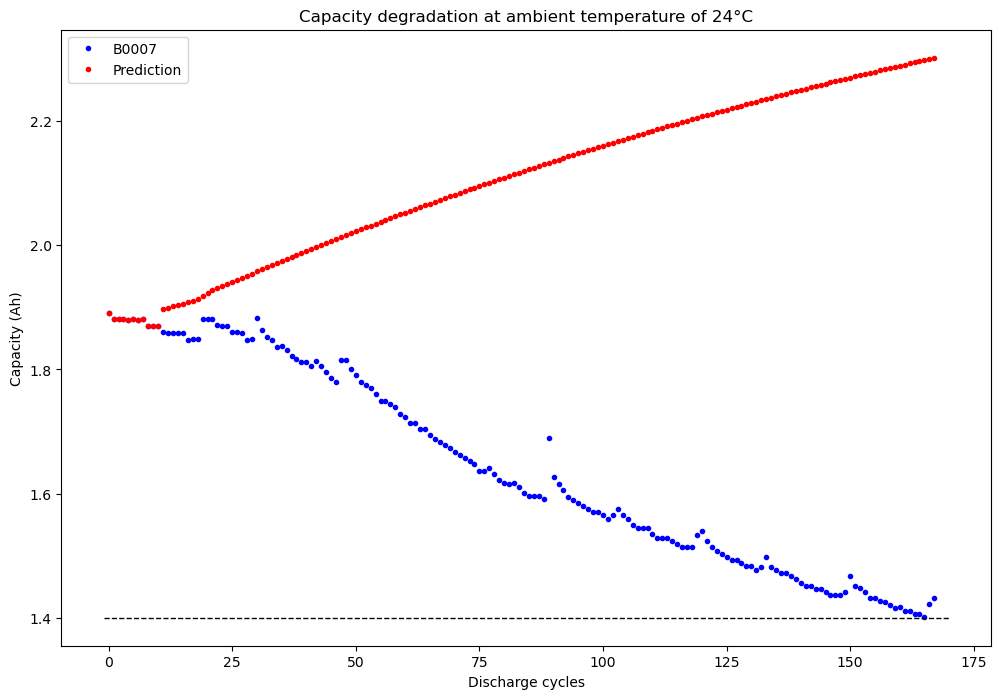

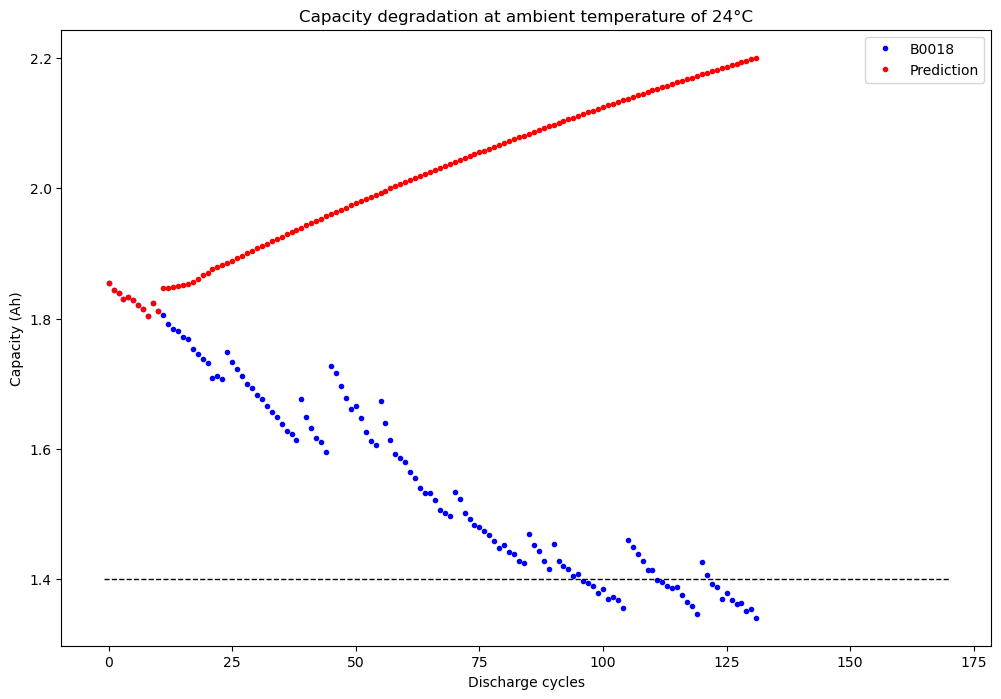

In [247]:
for name in plot_data:
    real,pred = plot_data[name]['real'], plot_data[name]['pred']
    plot(name=name,
         real_data=real,
        pred_data=pred)

# 4 SVM回归

## 4.1 LinearSVR

In [171]:
from sklearn.svm import LinearSVR

In [248]:
model = LinearSVR(loss='squared_epsilon_insensitive',
                  max_iter=50_000)

In [249]:
model = regressor_trainer(model,bmap)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:39<00:00, 25.34it/s]

Model:LinearSVR(loss='squared_epsilon_insensitive', max_iter=50000)
MAE:0.0896 RMSE:0.0986


In [250]:
plot_data = regressor_line_predictor(model,bmap)   

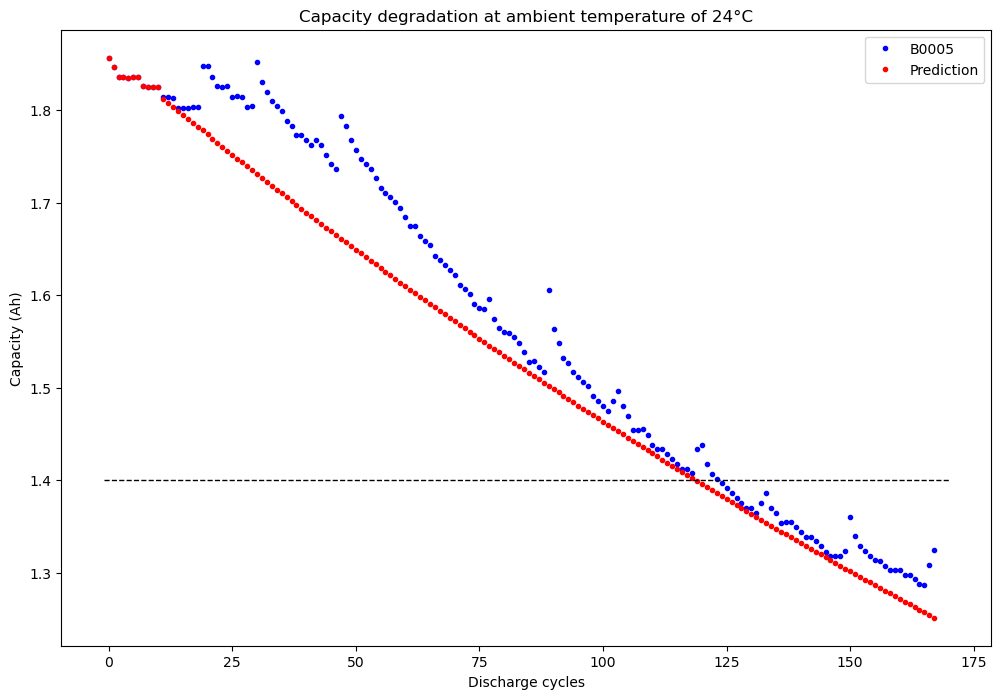

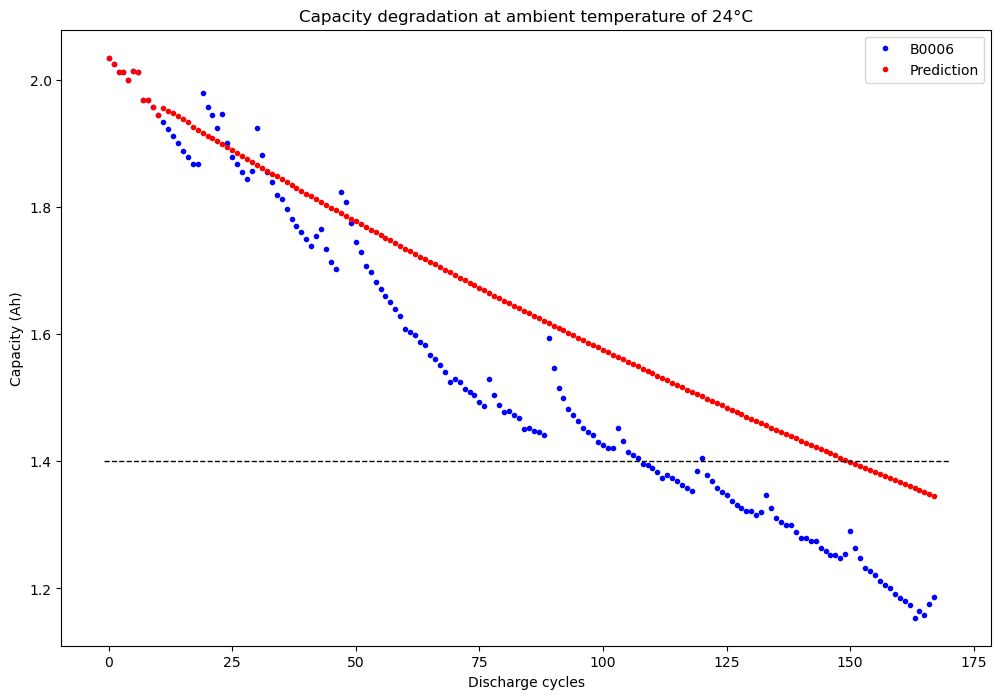

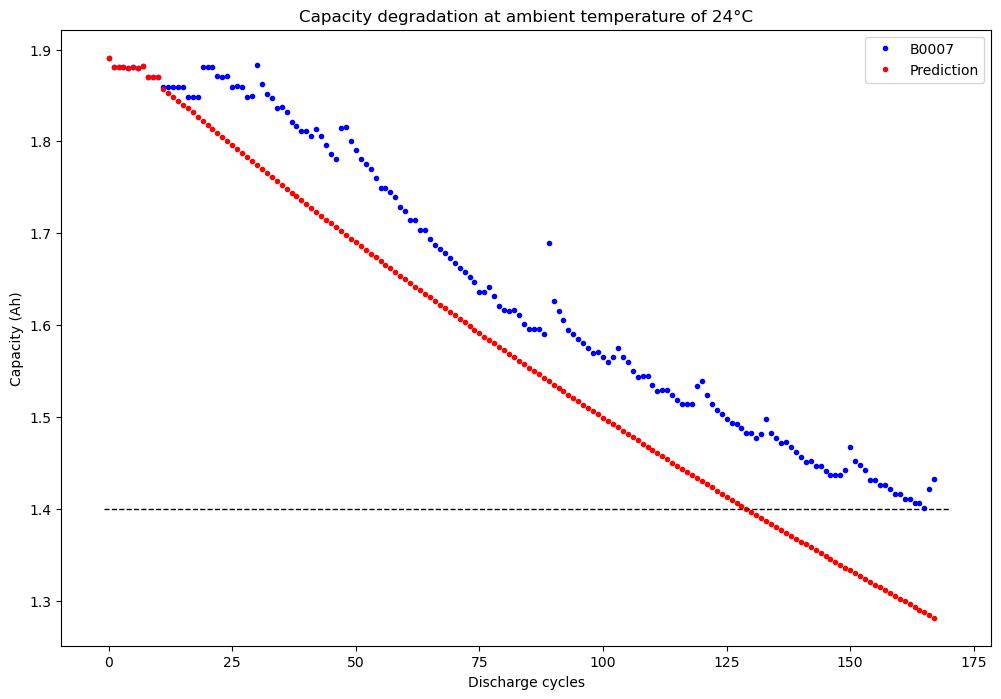

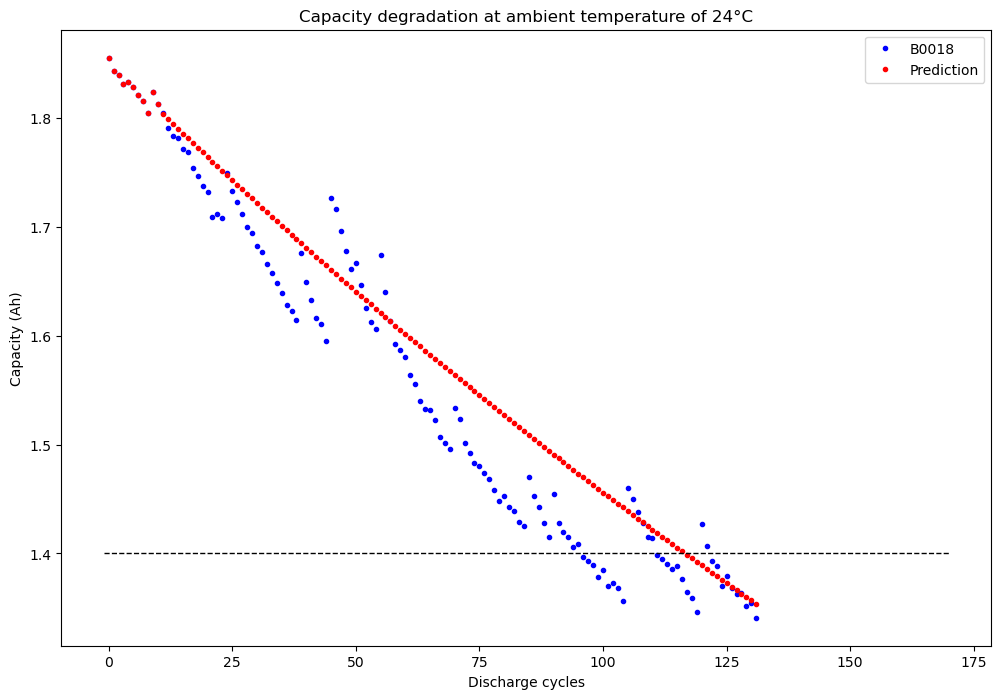

In [251]:
for name in plot_data:
    real,pred = plot_data[name]['real'], plot_data[name]['pred']
    plot(name=name,
         real_data=real,
        pred_data=pred)

## 4.2 SVR

In [178]:
from sklearn.svm import SVR

In [252]:
model = SVR(kernel='sigmoid')

In [253]:
model = regressor_trainer(model,bmap)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:26<00:00, 37.80it/s]

Model:SVR(kernel='sigmoid')
MAE:0.1604 RMSE:0.1857


In [254]:
plot_data = regressor_line_predictor(model,bmap)   

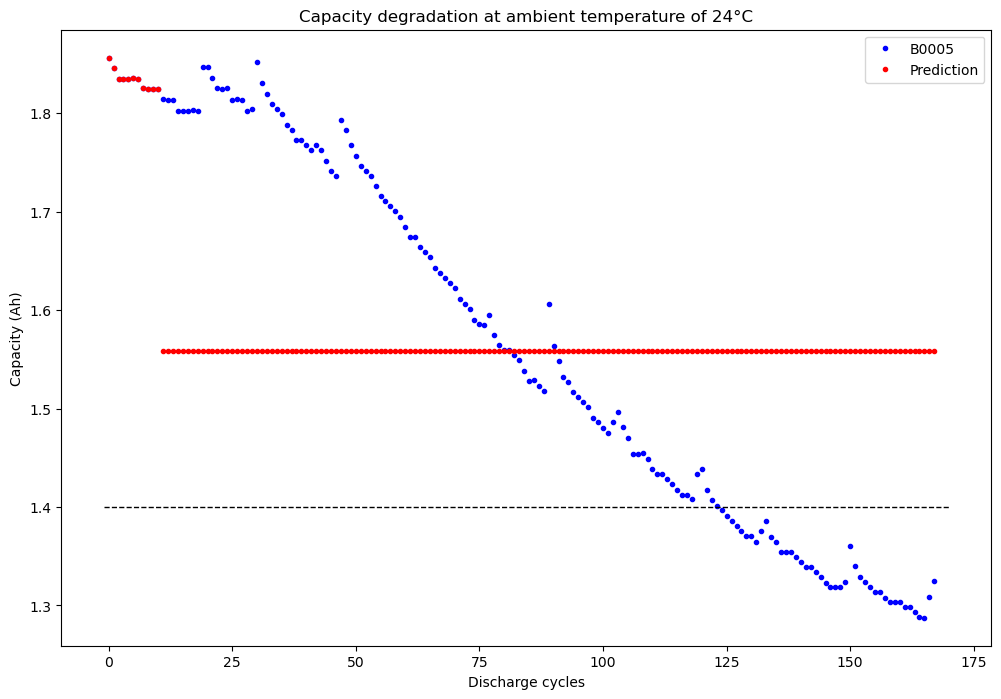

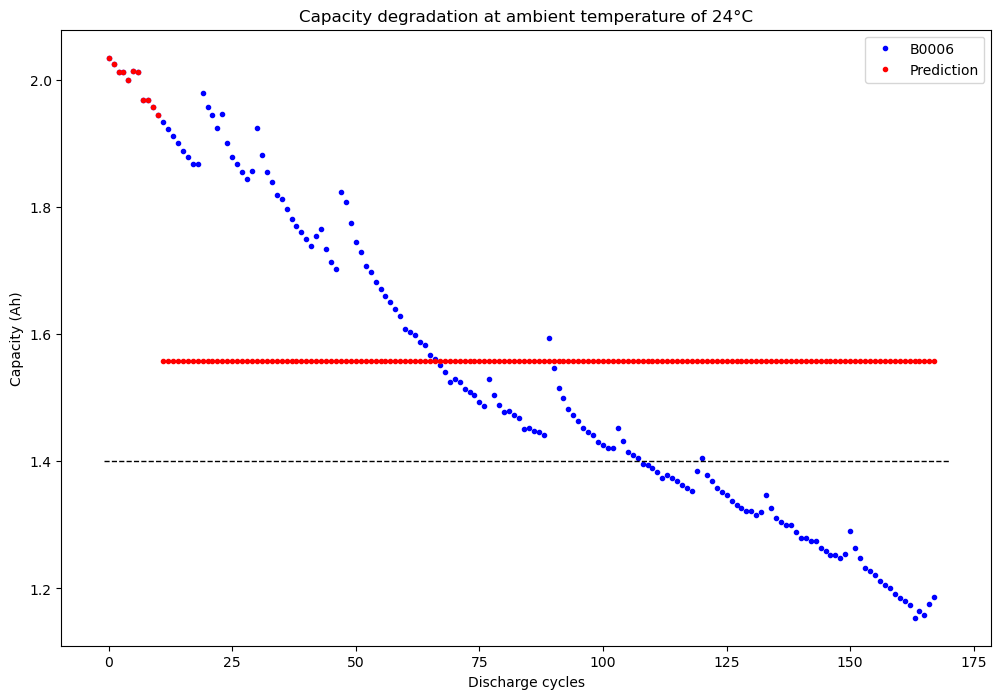

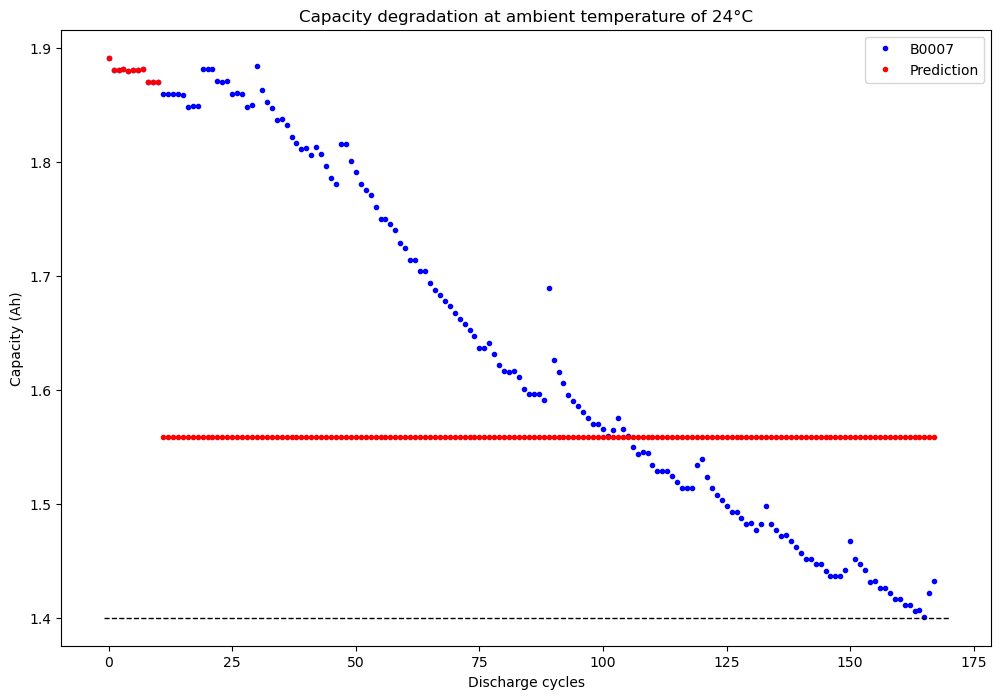

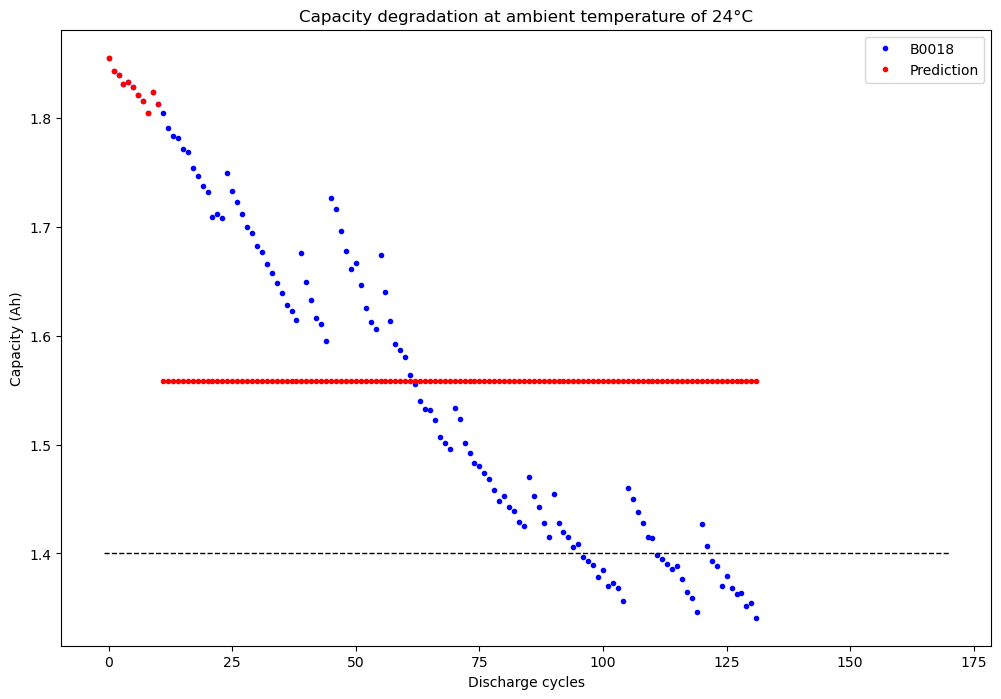

In [255]:
for name in plot_data:
    real,pred = plot_data[name]['real'], plot_data[name]['pred']
    plot(name=name,
         real_data=real,
        pred_data=pred)

# 5 树回归

In [183]:
import xgboost

In [512]:
model = xgboost.XGBRegressor(
    objective='reg:squaredlogerror', # reg:squarederror reg:logistic reg:squaredlogerror
    n_estimators=2000,
    tree_method='hist',
    colsample_bytree=1,
    max_depth=18,
    max_leaves=0,
    subsample=0.7,
    sampling_method='gradient_based', # uniform gradient_based
    # reg_alpha=0.8,
    # reg_lambda=0.9,
    grow_policy='depthwise',# depthwise lossguide
    learning_rate = 0.125,
    device='cuda',
)

In [513]:
model = regressor_trainer(model,bmap,epoch=1,eval_step=1,on_test_log=False)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:39<00:00, 39.84s/it]

Model:XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy='depthwise', importance_type=None,
             interaction_constraints=None, learning_rate=0.125, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=18, max_leaves=0,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2000, n_jobs=None,
             num_parallel_tree=None, objective='reg:squaredlogerror', ...)
MAE:0.0703 RMSE:0.0839


In [514]:
plot_data = regressor_line_predictor(model,bmap)   

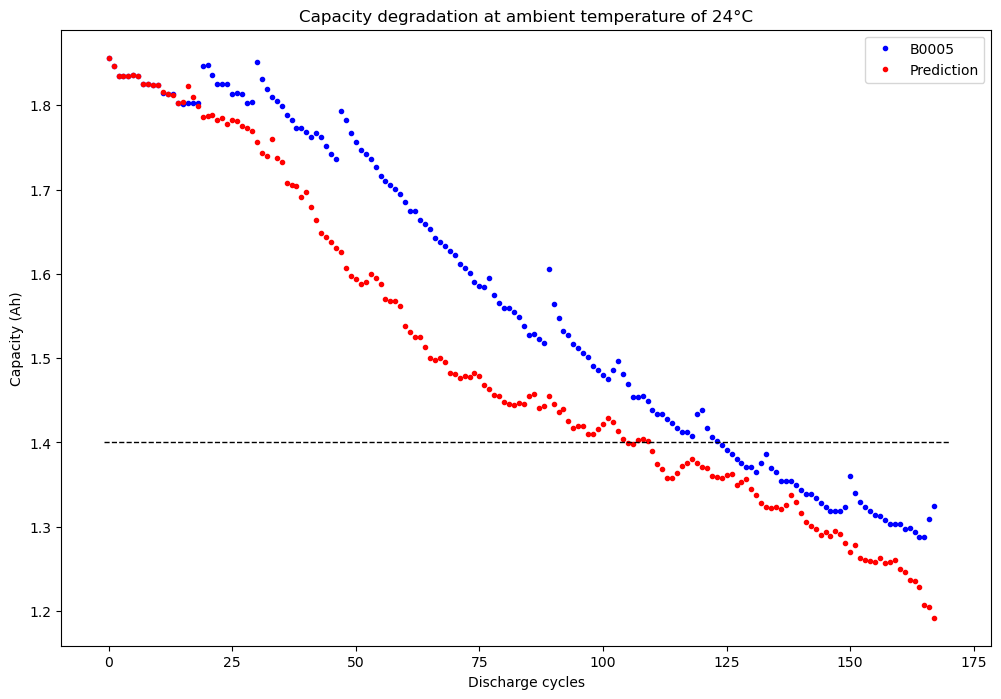

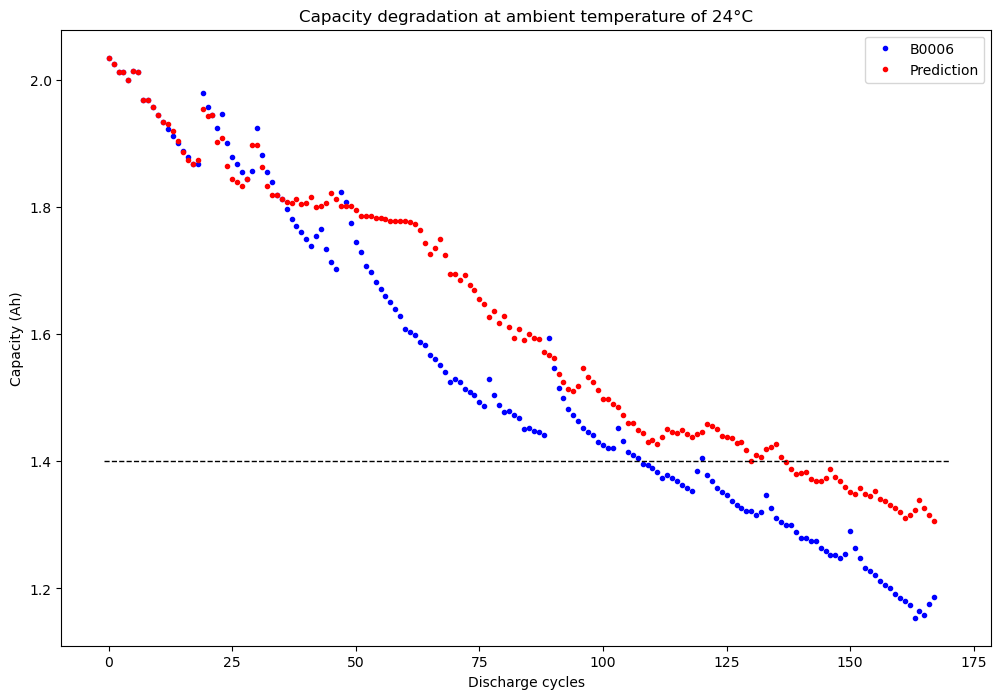

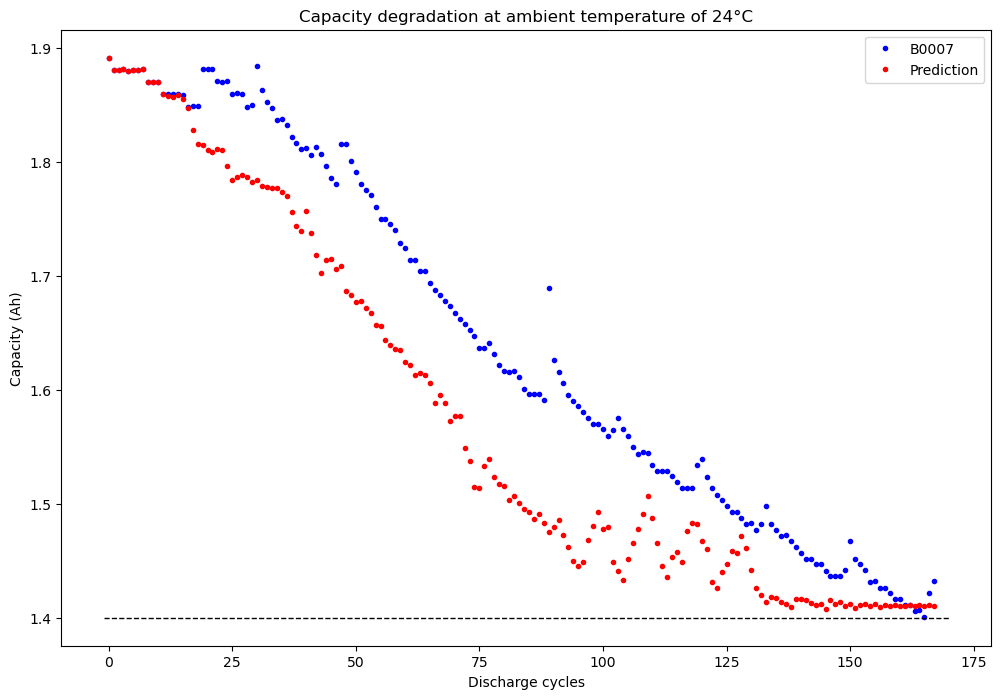

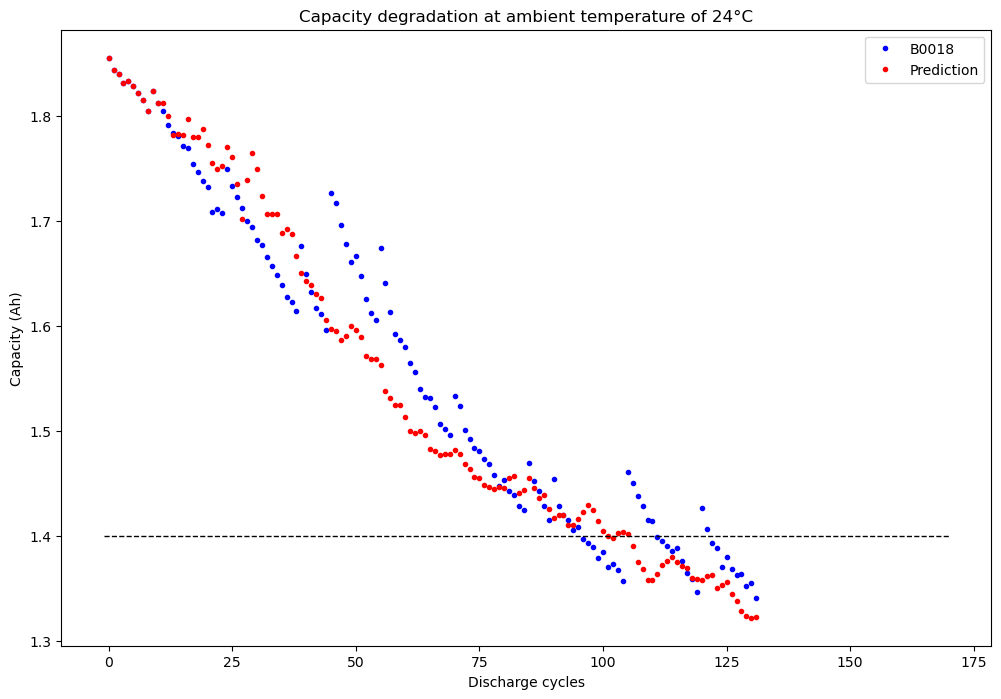

In [515]:
for name in plot_data:
    real,pred = plot_data[name]['real'], plot_data[name]['pred']
    plot(name=name,
         real_data=real,
        pred_data=pred)